In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as torch_nn
import torchaudio
import dsp as nii_dsp
import torch.nn.functional as torch_nn_func

def trimf(x, params):
    """
    trimf: similar to Matlab definition
    https://www.mathworks.com/help/fuzzy/trimf.html?s_tid=srchtitle
    
    """
    if len(params) != 3:
        print("trimp requires params to be a list of 3 elements")
        sys.exit(1)
    a = params[0]
    b = params[1]
    c = params[2]
    if a > b or b > c:
        print("trimp(x, [a, b, c]) requires a<=b<=c")
        sys.exit(1)
    y = torch.zeros_like(x, dtype=torch.float32)
    if a < b:
        index = torch.logical_and(a < x, x < b)
        y[index] = (x[index] - a) / (b - a)
    if b < c:    
        index = torch.logical_and(b < x, x < c)              
        y[index] = (c - x[index]) / (c - b)
    y[x == b] = 1
    return y 


def delta(x):
    """ By default
    input
    -----
    x (batch, Length, dim)
    
    output
    ------
    output (batch, Length, dim)
    
    Delta is calculated along Length dimension
    """
    length = x.shape[1]
    output = torch.zeros_like(x)
    x_temp = torch_nn_func.pad(x.unsqueeze(1), (0, 0, 1, 1), 
                               'replicate').squeeze(1)
    output = -1 * x_temp[:, 0:length] + x_temp[:,2:]
    return output


def linear_fb(fn, sr, filter_num):
    """linear_fb(fn, sr, filter_num)
    create linear filter bank based on trim
    input
    -----
      fn: int, FFT points
      sr: int, sampling rate (Hz)
      filter_num: int, number of filters in filter-bank
    
    output
    ------
      fb: tensor, (fn//2+1, filter_num)
    Note that this filter bank is supposed to be used on 
    spectrum of dimension fn//2+1.
    See example in LFCC.
    """
    # build the triangle filter bank
    f = (sr / 2) * torch.linspace(0, 1, fn//2+1)
    filter_bands = torch.linspace(min(f), max(f), filter_num+2)
        
    filter_bank = torch.zeros([fn//2+1, filter_num])
    for idx in range(filter_num):
        filter_bank[:, idx] = trimf(
            f, [filter_bands[idx], 
                filter_bands[idx+1], 
                filter_bands[idx+2]])
    return filter_bank


class LFCC(torch_nn.Module):
    """ Based on asvspoof.org baseline Matlab code.
    Difference: with_energy is added to set the first dimension as energy
    """
    def __init__(self, fl, fs, fn, sr, filter_num, num_ceps, is_cmvn,
                 with_energy=False, with_emphasis=False,
                 with_delta=True):
        """ Initialize LFCC
        
        Para:
        -----
          fl: int, frame length, (number of waveform points)
          fs: int, frame shift, (number of waveform points)
          fn: int, FFT points
          sr: int, sampling rate (Hz)
          filter_num: int, number of filters in filter-bank
          with_energy: bool, (default False), whether replace 1st dim to energy
          with_emphasis: bool, (default True), whether pre-emphaze input wav
          with_delta: bool, (default True), whether use delta and delta-delta
        
          for_LFB: bool (default False), reserved for LFB feature
        """
        super(LFCC, self).__init__()
        self.fl = fl
        self.fs = fs
        self.fn = fn
        self.sr = sr
        self.filter_num = filter_num
        self.num_ceps = num_ceps
        self.is_cmvn = is_cmvn
        self.dim = [1]
        self.eps = 1e-10

        self.mask = torchaudio.transforms.FrequencyMasking(filter_num//5)
        
        # build the triangle filter bank
        f = (sr / 2) * torch.linspace(0, 1, fn//2+1)
        filter_bands = torch.linspace(min(f), max(f), filter_num+2)
        
        filter_bank = torch.zeros([fn//2+1, filter_num])
        for idx in range(filter_num):
            filter_bank[:, idx] = trimf(
                f, [filter_bands[idx], 
                    filter_bands[idx+1], 
                    filter_bands[idx+2]])
        self.lfcc_fb = torch_nn.Parameter(filter_bank, requires_grad=False)

        # DCT as a linear transformation layer
        self.l_dct = nii_dsp.LinearDCT(filter_num, 'dct', norm='ortho')

        # opts
        self.with_energy = with_energy
        self.with_emphasis = with_emphasis
        self.with_delta = with_delta
        return
    
    def forward(self, x, is_mask):
        """
        
        input:
        ------
         x: tensor(batch, length), where length is waveform length
        
        output:
        -------
         lfcc_output: tensor(batch, frame_num, dim_num)
        """
        # pre-emphsis 
        if self.with_emphasis:
            x[:, 1:] = x[:, 1:]  - 0.97 * x[:, 0:-1]
        
        # STFT
        x_stft = torch.stft(x, self.fn, self.fs, self.fl, 
                            window=torch.hamming_window(self.fl).to(x.device), 
                            onesided=True, pad_mode="constant", return_complex=False)        
        # amplitude
        sp_amp = torch.norm(x_stft, 2, -1).pow(2).permute(0, 2, 1).contiguous()
        
        # filter bank   (batch, frame_num, filter_num)
        fb_feature = torch.log10(torch.matmul(sp_amp, self.lfcc_fb) + 
                                 torch.finfo(torch.float32).eps)
        
        # DCT (if necessary, remove DCT)   (batch, frame_num, filter_num)
        lfcc = self.l_dct(fb_feature)[:,:,:self.num_ceps]
        # Add energy 
        if self.with_energy:
            power_spec = sp_amp / self.fn
            energy = torch.log10(power_spec.sum(axis=2)+ 
                                 torch.finfo(torch.float32).eps)
            lfcc[:, :, 0] = energy

        # Add delta coefficients
        if self.with_delta:
            lfcc_delta = delta(lfcc)
            lfcc_delta_delta = delta(lfcc_delta)
            lfcc_output = torch.cat((lfcc, lfcc_delta, lfcc_delta_delta), 2)
        else:
            lfcc_output = lfcc

        if self.is_cmvn:
            lfcc_output = (lfcc_output - lfcc_output.mean(self.dim, keepdim=True)) / (self.eps + lfcc_output.std(self.dim, keepdim=True))
        
        if is_mask:
            lfcc_output = self.mask(lfcc_output.permute(0, 2, 1)).permute(0, 2, 1)

        return lfcc_output


/Users/ozora-ogino/dev/asv/venv/lib/python3.9/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
def display_multiple_img(images, sr, rows = 3, cols=2,):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind, img in enumerate(images):
        ax.ravel()[ind].imshow(img)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'fig/{sr}.png')


hop = 4
sr = 16000

base_dir = "./asv"
spoof_dir = os.path.join(base_dir, 'spoof')
bonafide_dir = os.path.join(base_dir, 'bonafide')

spoof_files = ['PA_E_0136321', 'PA_E_0136258', 'PA_E_0135766']
bonafide_files = ['PA_E_0135251', 'PA_E_0135541', 'PA_E_0136967']

ns = [256, 512, 1024, 2048, 4096, 8192]

In [3]:
def _get_spec(n_fft):
    hop = 8
    sr = 16000
    s = librosa.load(os.path.join(spoof_dir, 'PA_E_0136321.flac'), sr=16000)[0]
    b = librosa.load(os.path.join(bonafide_dir, 'PA_E_0135251.flac'), sr=16000)[0]
    s = s[None, :]
    b = b[None, :]
    s = torch.from_numpy(s)
    b = torch.from_numpy(b)
    stft = LFCC(n_fft, n_fft // hop, n_fft, sr, 70, 20, False, False)
    s = stft.forward(s, is_mask=False).numpy()[0]
    b = stft.forward(b, is_mask=False).numpy()[0]
    return s, b

In [4]:
s, b = _get_spec(512)

/Users/ozora-ogino/dev/asv/dsp.py:173: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:590.)
  Vc = torch.rfft(v, 1, onesided=False)


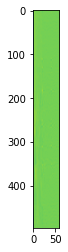

In [8]:
plt.imshow(b[:, :200])

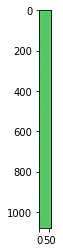

In [9]:
plt.imshow(s[:, :])

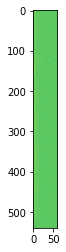

In [10]:
s, b = _get_spec(1024)
plt.imshow(s[:, -200:])

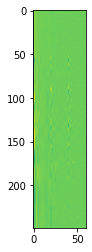

In [11]:
plt.imshow(b[:, -100:])

In [34]:
s, b = _get_spec(2048)

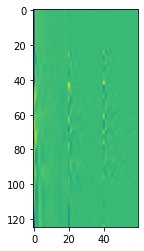

In [35]:
plt.imshow(b[:, :])

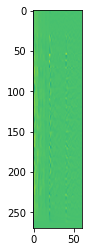

In [36]:
plt.imshow(s[:, :])

In [17]:
def _show_concat_img(s, b, l=800):
    con = np.concatenate([b, np.zeros([s.shape[0]-b.shape[0], s.shape[1]])])
    img = np.stack([s, con, np.zeros(s.shape)]).transpose(1,2,0)
    plt.imshow(img[:, :l])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


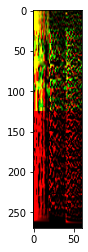

In [18]:
_show_concat_img(s, b)

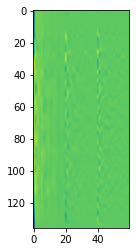

In [38]:
s, b = _get_spec(4092)
plt.imshow(s[:, :])

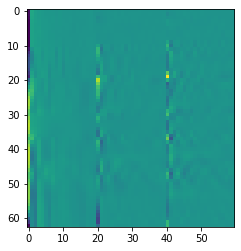

In [39]:
plt.imshow(b[:, :])

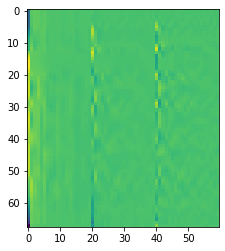

In [40]:
s, b = _get_spec(8192)
plt.imshow(s[:, :])

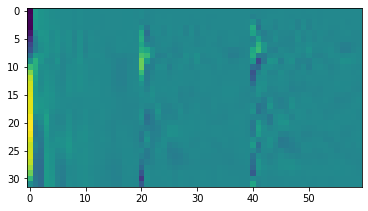

In [41]:
s, b = _get_spec(8192)
plt.imshow(b[:, :])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


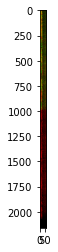

In [33]:
s, b = _get_spec(256)
_show_concat_img(s,b, s.shape[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


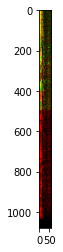

In [24]:
s, b = _get_spec(512)
_show_concat_img(s,b, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


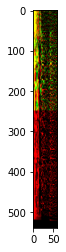

In [25]:
s, b = _get_spec(1024)
_show_concat_img(s,b, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


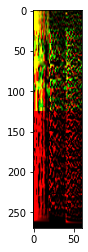

In [31]:
s, b = _get_spec(2048)
_show_concat_img(s,b, s.shape[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


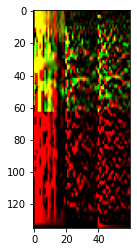

In [32]:
s, b = _get_spec(4096)
_show_concat_img(s,b, s.shape[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


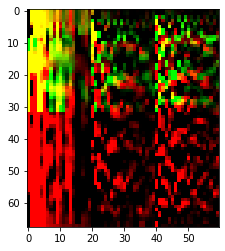

In [43]:
s, b = _get_spec(8192)
_show_concat_img(s,b, s.shape[1])